In [1]:
import os.path

import matplotlib.pyplot as plt
import math
import pathlib

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import trange, tqdm

import score_based_sampling.models as models
from score_based_sampling.train_score_model import train_score_model, estimate_max_distance_in_dataset

gpu_id = 0
device = torch.device(f'cuda:{gpu_id}')

#Load data
train_bs = 128
val_bs = 512

dataset_dir = 'datasets/CIFAR10'
p = pathlib.Path(dataset_dir).mkdir(parents=True, exist_ok=True)

train_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToTensor()
        ])

train_dataset = torchvision.datasets.CIFAR10(dataset_dir, train=True, download=True,
                                           transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=train_bs, shuffle=True)

val_dataset = torchvision.datasets.CIFAR10(dataset_dir, train=False, download=True,
                                         transform=torchvision.transforms.ToTensor())
val_loader = DataLoader(val_dataset, batch_size=val_bs, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [2]:
#Noise scales
N_sigma_estimation_samples = min(10_000, len(train_dataset))
sigma_estimation_samples = torch.zeros((N_sigma_estimation_samples, 3, 32, 32))
collected_samples = 0

train_iter = iter(train_loader)
while collected_samples < N_sigma_estimation_samples:
    data = next(train_iter)[0]
    samples_to_collect_from_batch = min(len(data), N_sigma_estimation_samples - collected_samples)
    data = data[:samples_to_collect_from_batch]
    sigma_estimation_samples[collected_samples:(collected_samples + samples_to_collect_from_batch)] = data

    collected_samples += samples_to_collect_from_batch

max_sigma = estimate_max_distance_in_dataset(sigma_estimation_samples.view(N_sigma_estimation_samples, -1))
min_sigma = 0.01
N_noise_scales = 250
print(f'Estimated Max Sigma {max_sigma}')

#roughly 50, so we fix it to 50 to be able to load model and use it on the exact same sigma it was trained on
max_sigma = 50

#geometric series with common ratio gamma
gamma = (min_sigma / max_sigma) ** (1 / (N_noise_scales - 1))
sigmas = max_sigma * gamma ** (torch.arange(0, N_noise_scales))
sigmas = sigmas.to(device)

print(f'Max sigma {max_sigma:.3f} - Min Sigma {min_sigma:.3f} - Num scales {N_noise_scales} - Gamma {gamma:.3f}')

Estimated Max Sigma 51.562374114990234
Max sigma 50.000 - Min Sigma 0.010 - Num scales 250 - Gamma 0.966


In [3]:
#load our model
epochs = 500
lr = 0.0001
optim = 'adam'
scheduler = 'none'
ema = True
modelname = 'ncsnv2'

if modelname == 'unet':
    model = models.get_CIFAR_UNet_Large(sigmas)
elif modelname == 'ncsnv2':
    model = models.get_CIFAR_NCSNv2(sigmas)
else:
    raise NotImplemented

model_chkpt_filename = f'cifar_{modelname}_{N_noise_scales}_{ema}.pth'
if os.path.isfile(model_chkpt_filename):
    print('Loading model checkpoint from file')
    model.load_state_dict(torch.load(model_chkpt_filename))
    model.to(device)
else:
    model.to(device)
    print('Starting score net training...')
    model = train_score_model(model, sigmas, train_loader, lr, epochs, device, optim=optim, scheduler=scheduler, ema=ema,val_loader=val_loader)
    torch.save(model.state_dict(), model_chkpt_filename)
    print('Training done')

Starting score net training...
Epoch 0 - Avg train loss 315.5693054199219
Val loss 212.76222229003906
Epoch 1 - Avg train loss 197.81826782226562
Val loss 185.1637725830078
Epoch 2 - Avg train loss 180.51681518554688
Val loss 173.9232177734375
Epoch 3 - Avg train loss 172.6236114501953
Val loss 167.68563842773438
Epoch 4 - Avg train loss 167.88661193847656
Val loss 163.4349822998047
Epoch 5 - Avg train loss 165.06729125976562
Val loss 160.39610290527344
Epoch 6 - Avg train loss 161.69027709960938
Val loss 157.79104614257812
Epoch 7 - Avg train loss 159.48611450195312
Val loss 155.7545623779297
Epoch 8 - Avg train loss 157.00942993164062
Val loss 153.6508331298828
Epoch 9 - Avg train loss 156.5301971435547
Val loss 152.63531494140625
Epoch 10 - Avg train loss 155.2803497314453
Val loss 151.26296997070312
Epoch 11 - Avg train loss 153.411376953125
Val loss 150.03248596191406
Epoch 12 - Avg train loss 153.55995178222656
Val loss 149.0185089111328
Epoch 13 - Avg train loss 152.314743041992

250it [00:21, 11.87it/s]


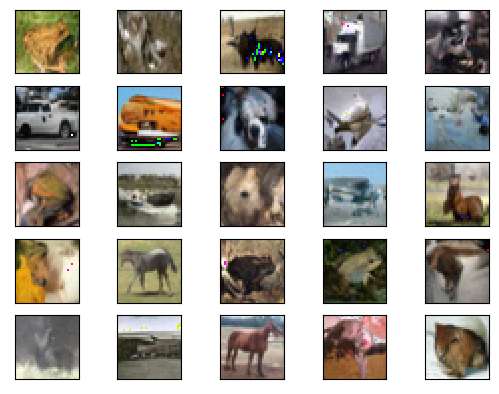

In [8]:
#Langevin samples - Multiple Noise Scales
num_samples = 25
sampling_steps_per_noise_scale = 5
eps = 0.000005

#https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/
#https://en.wikipedia.org/wiki/Stochastic_gradient_Langevin_dynamics
ns_samples = torch.rand((num_samples, 3, 32, 32), device=device)

model.eval()
with torch.no_grad():
    for sigma_idx, sigma in tqdm(enumerate(sigmas)):
        noise_scale_idcs = sigma_idx * torch.ones(num_samples, dtype=torch.long, device=device)
        alpha = eps * (sigma / min_sigma) ** 2
        for _ in range(sampling_steps_per_noise_scale):
            score = model(ns_samples, noise_scale_idcs)
            noise = torch.randn_like(ns_samples, device=device)
            ns_samples = ns_samples + alpha * score + math.sqrt(2 * alpha) * noise

    #last denoise
    score = model(ns_samples, noise_scale_idcs)
    ns_samples = ns_samples + alpha * score


ns_samples = ns_samples.detach().cpu()
N_cols = int(math.ceil(math.sqrt(num_samples)))
N_rows = int(math.ceil(num_samples / N_cols))

fig, axs = plt.subplots(N_rows, N_cols)
for i in range(N_rows):
    for j in range(N_cols):
        lin_Idx = i * N_cols + j
        img = ns_samples[lin_Idx]
        img = torchvision.transforms.functional.to_pil_image(img)
        axs[i, j].imshow(np.asarray(img))
        axs[i, j].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
